# MCMC using backward filtering, forward guiding for shapes with SDE transitions

Parameter inference for trees with Brownian flows (Kunita flows) transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebooks [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb), [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb), [mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb](mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb) for simplified versions. The covariance of each stochastic step is shape dependent and the processes nonlinear, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import DownLambda, UpDownLambda
from hyperiax.models.functional import sum_fuse_children
from hyperiax.tree.updaters import update_noise_inplace
from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.tree.plot_utils import plot_tree_shape
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

# Shape related setup

In [4]:
# plotting
def plot_shape(q):
    q = q.reshape((-1,d))
    plt.plot(q[:,0],q[:,1],'.')
    plt.axis('equal')

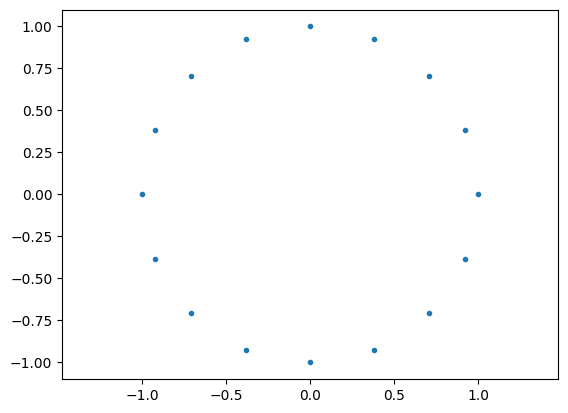

In [5]:
# define shape and plot
d = 2; n = 16 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape(root)

Covariance, diffusion, drift and SDE integration forward/backwards

In [6]:
# diffusion and covariance specification for shape processes
# This version assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: params['k_alpha']*jnp.exp(-.5/params['k_sigma']*jnp.sum(jnp.square(x),2))

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmax = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmax,sigmax) # covariance
# multiply on the factorized matrix, e.g. covariance matrix
dot = lambda A,v: jnp.einsum('ij,jd->id',A,v.reshape((n,d))).flatten()
# multiple on inverse factorized matrix, e.g. inverse covariance matrix
solve = lambda A,v: jnp.linalg.solve(A,v.reshape((n,d))).flatten()

# SDE integration, unconditional and guided

In [7]:
n_steps = 1000 # number of time steps in the discretization

# time increments
def dts(T=1.,n_steps=100):
    return jnp.array([T/n_steps]*n_steps)

 # drift
def b(t,x,params): return jnp.zeros(n*d)
# the diffusion field is sigma as define above

# forward sampling along edge unconditional, Euler-Maruyama
def forward(x,dts,dWs,b,sigma,params):
    def SDE(carry, val):
        t,X = carry
        dt,dW = val
        
        # SDE
        Xtp1 = X + b(t,X,params)*dt + dot(sigma(x,params),dW.reshape((n,d)))
        tp1 = t + dt
        
        return((tp1,Xtp1),(t,X))    

    # sample
    (T,X), (ts,Xs) = jax.lax.scan(SDE,(0.,x),(dts,dWs))
    Xs = jnp.vstack((Xs,X))
    return Xs

# forward guided sampling, assumes already backward filtered
def forward_guided(x,H,F,tildea,dts,dWs,b,sigma,params):
    tildebeta = lambda t,params: jnp.zeros(n*d)
    tildeb = lambda t,x,params: tildebeta(t,params) #+jnp.dot(tildeB,x) #tildeB is zero for now

    def bridge_SFvdM(carry, val):
        t, X, logpsi = carry
        dt, dW, H, F = val
        tilderx =  F-dot(H,X)
        _sigma = sigma(x,params)
        _a = jnp.einsum('ij,kj->ik',_sigma,_sigma)
        
        # SDE
        Xtp1 = X + b(t,X, params)*dt + dot(_a,tilderx)*dt + dot(_sigma,dW)
        tp1 = t + dt
        
        # logpsi
        amtildea = _a-tildea
        logpsicur = logpsi+(
                jnp.dot(b(t,X,params)-tildeb(t,X,params),tilderx)
                -.5*jnp.einsum('ij,ji->',amtildea,H)
                +.5*jnp.einsum('ij,jd,id->',
                           amtildea,tilderx.reshape((n,d)),tilderx.reshape((n,d)))
                    )*dt
        return((tp1,Xtp1,logpsicur),(t,X,logpsi))    

    # sample
    (T,X,logpsi), (ts,Xs,logpsis) = jax.lax.scan(bridge_SFvdM,(0.,x,0.),(dts,dWs,H,F))
    Xscirc = jnp.vstack((Xs, X))
    return Xscirc,logpsi


# Tree with SDE transitions

First, we initialize the tree. We set the root to the shape defined above.

In [8]:
# create tree and initialize with noise
tree = hyperiax.tree.builders.symmetric_tree(2,5)
print('Tree:',tree)

# set edge lengths on all nodes
edge_length = 1.
tree['edge_length'] = edge_length

# data dimension
d = 2

# root value
tree.root['value'] = root

Tree: HypTree with 3 levels and 31 nodes


We then define parameters for the Gaussian transition kernel.

In [9]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions using the SDE functions above. The step covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [10]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps); _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs = forward(parent_value.reshape((-1,n*d))[-1],_dts,_dWs,b,sigma,params)
        return {'value': Xs}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = LevelwiseTreeExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [11]:
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (n_steps,n*d,))
dtree = down_unconditional.down(noise_tree,params.values())

Add uncorrelated observation noise to leaves.



In [12]:
# copy the sampled tree and add noise to leaf nodes
leaf_tree = dtree.copy()
for node in leaf_tree.iter_leaves():
    key, subkey = split(key)
    node['value'] = node['value'].at[-1].add(jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey, node['value'][-1].shape)) # add observation noise to the last entry

Plot a generated tree.

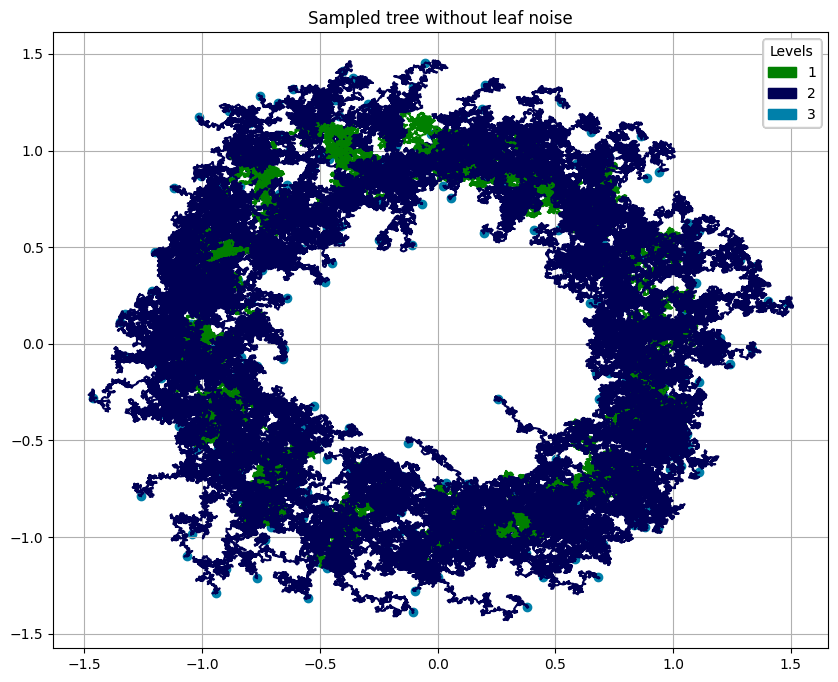

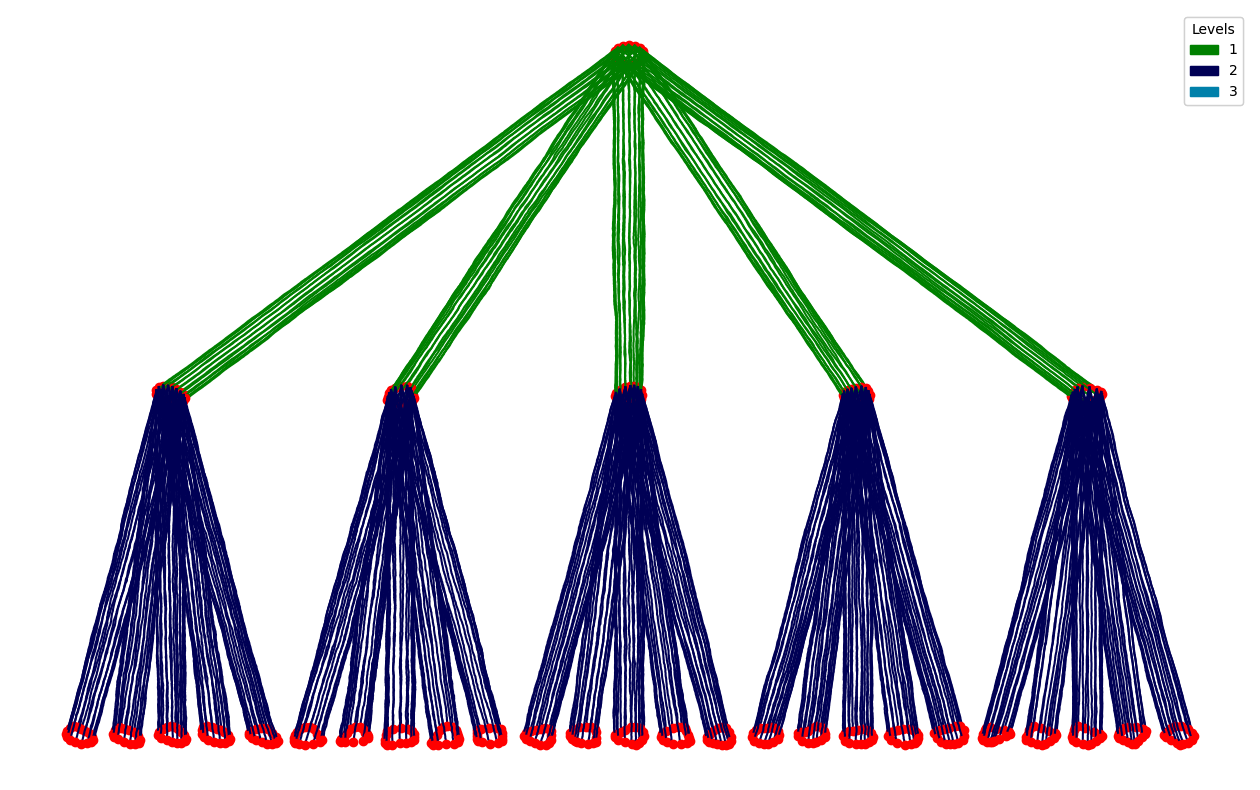

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
for i in range(n):
    dtree.plot_tree_2d(selector=lambda z: z['value'].reshape((-1,n,d))[:,i],ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_shape(dtree,shape="value")

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [14]:
# functions for pullback and likelihood ratios, see https://arxiv.org/abs/2203.04155 section 6.1 for details
quadratic = lambda x,H: jnp.dot(x,jnp.dot(H,x))
logphi = lambda x,mu,Sigma: jax.scipy.stats.multivariate_normal.logpdf(x,mu,Sigma) # log Gaussian density given precision matrix H
phi = lambda x,mu,Sigma: jax.scipy.stats.multivariate_normal.pdf(x,mu,Sigma) # Gaussian density in standard form
omega = lambda Sigma: (jnp.linalg.det(Sigma)*(2*jnp.pi)**Sigma.shape[0])**(-.5) # normalization constant for Gaussian
omega_H = lambda H: jnp.sqrt(jnp.linalg.det(H)/((2*jnp.pi)**H.shape[0])) # normalization constant for Gaussian
logomega = lambda Sigma: .5*(-jnp.linalg.slogdet(Sigma)[1]-jnp.log(2*jnp.pi)*Sigma.shape[0]) # log normalization constant for Gaussian
logomega_H = lambda H: .5*(jnp.linalg.slogdet(H)[1]-jnp.log(2*jnp.pi)*H.shape[0]) # log normalization constant for Gaussian
logphi_H = lambda x,mu,H:  logomega_H(H)-.5*quadratic(x-mu,H) # log Gaussian density in standard form
phi_H = lambda x,mu,H: jnp.exp(logphi_H(x,mu,H))
#logphi_can = lambda y,F,H: logomega_H(H)-.5*jnp.dot(F,jnp.solve(H,F))-.5*jnp.einsum('i,ij,j->',y,H,y)+jnp.dot(F,y) # Gaussian density in canonical form with normalization
logphi_can = lambda y,F,H: logphi_H(y,jnp.linalg.solve(H,F),H)
phi_can = lambda y,F,H: jnp.exp(logphi_can(y,F,H))
logU = lambda y,c,F,H: c-.5*quadratic(y,H)+jnp.dot(F,y) # unnormalized Gaussian density in canonical form
U = lambda y,c,F,H: jnp.exp(logU(y,c,F,H))

In [15]:
# backwards filter
@jax.jit
def up(noise,edge_length,F_T,H_T,tildea,params,**args):
    def f(edge_length,F_T,H_T,tildea):
        var = edge_length # variance is edge length
        T = var # running time of Brownian motion

        _ts = jnp.cumsum(jnp.concatenate((jnp.array([0.]), dts(T=T,n_steps=n_steps))))[:-1]
        Phi_inv = lambda t:  jnp.eye(n)+H_T@tildea*(T-t)
        def step(carry, t): # integrate backwards
            H, F = carry
            dH = H@tildea@H; dF = dot(H@tildea,F)
            H_new = H-dH*(T/n_steps); F_new = F-dF*(T/n_steps) # negative sign because integration is backwards
            return (H_new, F_new), (H_new, F_new)
        _, (H, F) = jax.lax.scan(step, (H_T, F_T), _ts[::-1])
        H, F = H[::-1], F[::-1] # integrating backwards, so flip arrays
        v_T = solve(H_T,F_T)
        
        c_0 = jax.vmap(
            lambda v_T: logphi_H(jnp.zeros(n),v_T,H[0]),
            1)(v_T.reshape((n,d)))
        return {'c_0': c_0, 'F': F, 'H': H, 'tildea': tildea}# , 'subtree_var': subtree_var}
    return jax.vmap(f)(edge_length,F_T,H_T,tildea)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [16]:
# initialize tree for up
def init_up(tree,params):
    for node in tree.iter_bfs():
        if node.children and node.parent:
            del node.data['value']
        else:
            v = node['value'].reshape((-1,n*d))[-1]
            Sigma = params['obs_var'].value*jnp.eye(n)
            H = jnp.eye(n)/params['obs_var'].value
            F = dot(H,v)
            c = -jax.vmap(lambda w: jax.scipy.stats.multivariate_normal.logpdf(w,jnp.zeros(n),Sigma),1)(v.reshape((n,d)))
            tildea = a(v,params.values()) 
            #subtree_var = params['obs_var'].value
            node.data = {**node.data, 'c_T': c, 'F_T': F, 'H_T': H, 'tildea': tildea} #, 'subtree_var': subtree_var}

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [17]:
@jax.jit
def down_conditional(noise,edge_length,up_msg,parent_value,params,**args):
    def f(noise,edge_length,F,H,tildea,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps)
        _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs,logpsi = forward_guided(parent_value.reshape((-1,n*d))[-1],H,F,tildea,_dts,_dWs,b,sigma,params)
        return {'value': Xs, 'logpsi': logpsi}

    return jax.vmap(f)(noise,edge_length,up_msg['F'],up_msg['H'],up_msg['tildea'],parent_value)

We create the model and executor for the backwards filter (up) and forwards guiding (down).

In [18]:
# create model and executor
def fuse(child_c_0,child_F,child_H,params,**kwargs):
    F_T = jnp.sum(child_F[:,0], 0)
    H_T = jnp.sum(child_H[:,0], 0)
    c_T = jnp.sum(child_c_0, 0)
    #subtree_var = 1./jnp.sum(jnp.array([1./sv for sv in child_subtree_var]),0)
    #Mdagger = jnp.linalg.inv(H_T)
    v_T = solve(H_T,F_T)
    tildea = a(v_T,params) # v_T/subtree_var
    return {'c_T': c_T, 'F_T': F_T, 'H_T': H_T, 'tildea': tildea}#, 'subtree_var': subtree_var}
updownmodel = UpDownLambda(up_fn=up,fuse_fn=fuse,down_fn=down_conditional)
updown = LevelwiseTreeExecutor(updownmodel)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [19]:
# backwards filter and fowards guiding
utree = leaf_tree.copy()
init_up(utree,params)
utree = updown.up(utree,params.values())
utree.root['value'] = root
dtree_conditional = updown.down(utree,params.values())

# time the operations
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (n_steps,n*d,))
%time down_unconditional.down(noise_tree,params.values())
%time updown.up(utree,params.values())
updown.up(utree,params.values())
%time updown.up(utree,params.values())

CPU times: user 14.4 ms, sys: 2.57 ms, total: 16.9 ms
Wall time: 14.8 ms
CPU times: user 62 ms, sys: 15 ms, total: 77 ms
Wall time: 64.6 ms
CPU times: user 60.7 ms, sys: 10.8 ms, total: 71.5 ms
Wall time: 60.2 ms


HypTree with 3 levels and 31 nodes

# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.125, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.1, 'k_sigma': 0.25, 'obs_var': 0.001}


100%|██████████| 400/400 [01:36<00:00,  4.15it/s]

Acceptance rate: 0.4175


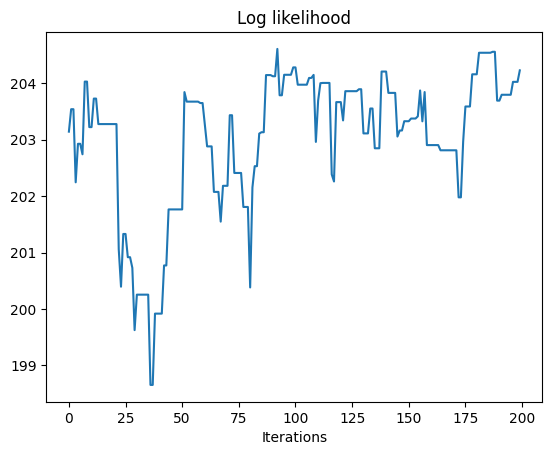

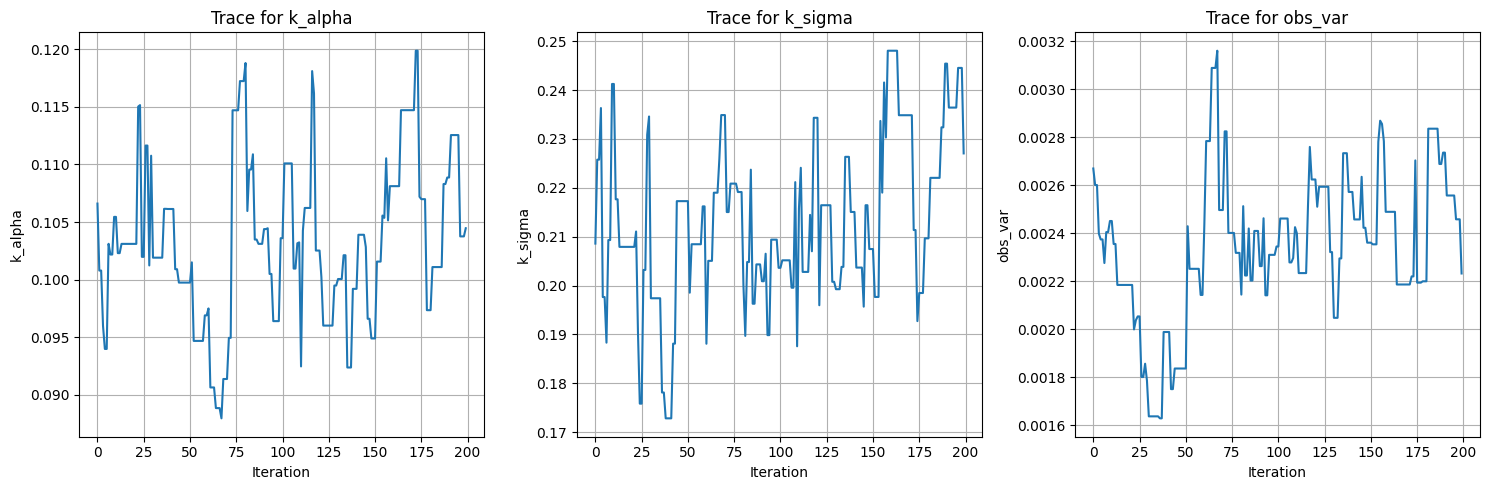

In [20]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = lambda node: .9
update_CN = lambda tree,key: update_noise_inplace(lambda node,new: node['noise']*lambd(node)+jnp.sqrt((1-lambd(node)**2))*new,tree,key)
zero_noise = lambda tree,key: update_noise_inplace(lambda node,new: jnp.zeros_like(node['noise']),tree,key)

# log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,tree = state
    v,c,F,H = tree.root['value'],tree.root['c_T'],tree.root['F_T'],tree.root['H_T']
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    tree.root['logpsi'] = 0.
    tree_logpsi = jnp.mean(jnp.array([node['logpsi'] for node in tree.iter_bfs()]))
    residuals = jnp.array([sample['value'][-1]-obs['value'][-1] for sample,obs in zip(tree.iter_leaves(),data.iter_leaves())]) 
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+tree_logpsi+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,tree = state

    # new tree with the leaf data
    utree = tree.copy(); 
    for data_leaf,utree_leaf in zip(data.iter_leaves(),utree.iter_leaves()):
        utree_leaf['value'] = data_leaf['value']

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # backwards filtering with updated parameters
    init_up(utree,new_parameters)
    utree = updown.up(utree,new_parameters.values())

    # update tree, CN update and forward filtering with the updated noise
    utree_CN = update_CN(utree,subkeys[1])
    dtree = updown.down(utree_CN,new_parameters.values())

    return new_parameters,dtree

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.125,alpha=3,beta=.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance. We keep it constant here because of lacking identifiability (which will not be the case with higher-dimensional correlated data)
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
leaf_tree.root['value'] = root
leaf_tree = zero_noise(leaf_tree,key)
utree = leaf_tree.copy(); init_up(utree,init_params);
init_state = (init_params,updown.down(updown.up(utree,init_params.values()),init_params.values()))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_tree, init_state, 200, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)